In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import scTRS.method as md
import matplotlib.pyplot as plt
import scTRS.util as util

In [2]:
adata = sc.read_h5ad("data/kang2018.h5ad")

In [3]:
adata = adata[adata.obs["multiplets"] != "doublet"]
median_umi = np.median(adata.X.sum(axis=1).A1)
sc.pp.normalize_total(adata, target_sum=median_umi)
sc.pp.log1p(adata)

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [5]:
GS_FILE = "/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs"
df_gs = pd.read_csv(GS_FILE, sep='\t')
df_gs.index = df_gs['TRAIT']

trait_list = ["UKB_460K.body_HEIGHTz", "PASS_Lupus", "PASS_Rheumatoid_Arthritis", "UKB_460K.blood_RED_COUNT", "UKB_460K.blood_MONOCYTE_COUNT"]
df_gs = df_gs[df_gs.TRAIT.isin(trait_list)]

In [6]:
df_res_dict = dict()
for trait in df_gs.index:
    print(trait)
    gene_list = df_gs.loc[trait,'GENESET'].split(',')
    df_res = md.score_cell(adata, gene_list, n_ctrl=500, 
                           return_ctrl_raw_score=False, 
                           return_ctrl_norm_score=True,
                           verbose=False)
    df_res_dict[trait] = df_res

PASS_Rheumatoid_Arthritis


/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


PASS_Lupus


/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


UKB_460K.blood_RED_COUNT


/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


UKB_460K.blood_MONOCYTE_COUNT


/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


UKB_460K.body_HEIGHTz


/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


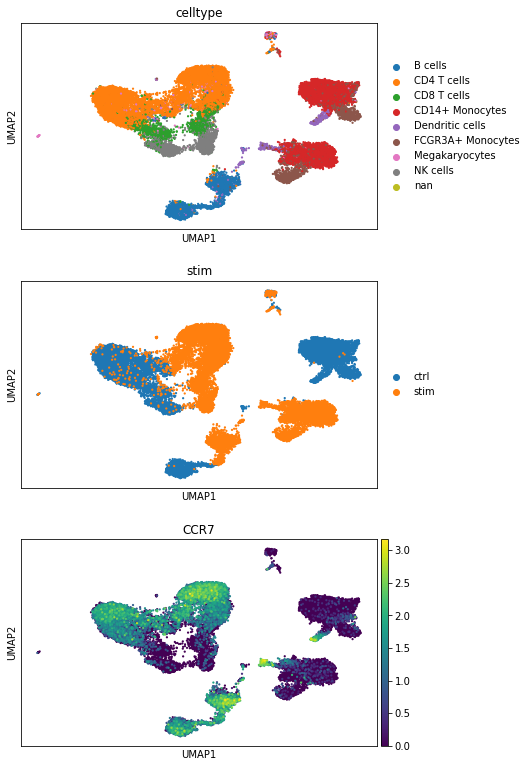

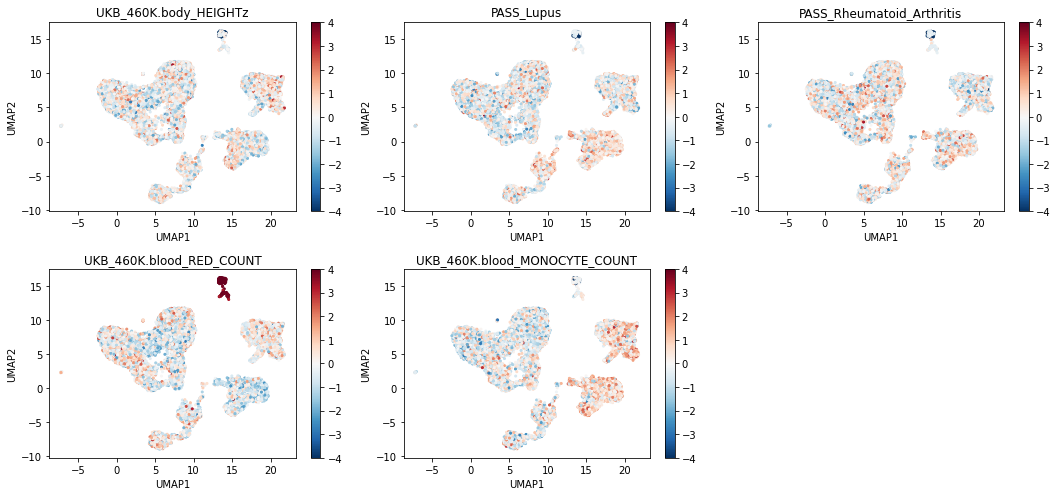

In [7]:
zsc_dict = dict()
for trait in trait_list:
    zsc_dict[trait] = df_res_dict[trait]["zscore"].reindex(adata.obs.index).values
score_index = adata.obs.index
util.plot_score_umap(zsc_dict, score_index, adata, n_col=3, umap_color=["celltype", "stim", "CCR7"]) 